<a href="https://colab.research.google.com/github/DonnaVakalis/nano/blob/master/Analyze_ab_test_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze A/B Test Results

 

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This project demonstrates an analysis of an A/B test run by a fictional e-commerce website. My goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.
 

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
!pip install statsmodels

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import statsmodels as sm

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHZO8sJwPqli6ZtAFWfVCsNMdV8VuH6hCStapQ5f-diQzsO98Xxa7A
Mounted at /content/gdrive


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
base_dir =  "/content/gdrive/My Drive/Colab Notebooks/UdacityAB/"
file = base_dir + "ab_data.csv"
df= pd.read_csv(file)
df.head()
 

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# read in countries data for later
file = base_dir + "countries.csv"
df_countries= pd.read_csv(file) 

b. Use the cell below to find the number of rows in the dataset.

In [7]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [8]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [9]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [5]:
no_match1 = df[df['group'] == 'treatment']['landing_page'] == 'old_page'
no_match2 = df[df['group'] == 'control']['landing_page'] == 'new_page'
print(sum(no_match1) + sum(no_match2))

3893


f. Do any of the rows have missing values?

In [11]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [6]:
# Remove rows where there is no match 
df_=df.copy()
df_.drop(no_match1.index)
df_.drop(no_match2.index)
df2=df_

In [7]:
df_=df.copy()
df_ = df_.drop(df_[(df['group'] == "treatment") & (df_['landing_page']=="old_page")].index) #drop mismatch type 1
df2 = df_.drop(df_[(df['group'] == "control") & (df_['landing_page']=="new_page")].index) #drop mismatch type 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [15]:
df2.user_id.nunique()

290584

In [16]:
df2.user_id.shape

(290585,)

b. There is one **user_id** repeated in **df2**.  What is it?

In [8]:
duplicatedID= df2[df2.duplicated(['user_id'])]
print(duplicatedID.user_id) #773192
 

2893    773192
Name: user_id, dtype: int64


c. What is the row information for the repeat **user_id**? 

In [18]:
print(duplicatedID)

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [9]:
df2.drop_duplicates(subset ="user_id", 
                     keep = "last", inplace = True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [10]:
control_p_converted = df2[df2['group']=="control"]['converted'].mean()
print(control_p_converted)

0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [11]:
treatment_p_converted=df2[df2['group']=="treatment"]['converted'].mean()
print(treatment_p_converted)

0.11880806551510564


d. What is the probability that an individual received the new page?

In [12]:
P_NEW = len(df2[df2['landing_page']=="new_page"].index)/len(df2.index)

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

We see a small difference but we can't know whether it is significant without doing a statistical test.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

Null Hypothesis: "The new page is the same or worse than the old page". 
**$p_{new}$** - **$p_{old}$** <= 0

Alternative Hypothesis: "The new page is better than the old page".
**$p_{new}$** - **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [13]:
# Null Hypothesis: Assume conversion rate is same for new/old and equal to mean
NULL_mu = df2.converted.mean()
SIZE = df2.shape[0]
print(NULL_mu,SIZE)

0.11959708724499628 290584


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [25]:
NULL_mu

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [26]:
NULL_mu

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [14]:
N_NEW=(P_NEW)*SIZE
N_NEW

145310.0

d. What is $n_{old}$, the number of individuals in the control group?

In [15]:
N_OLD=(1-P_NEW)*SIZE
N_OLD

145274.0

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [16]:
new_page_converted = np.random.binomial(N_NEW,NULL_mu)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [17]:
old_page_converted = np.random.binomial(N_OLD,NULL_mu)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [18]:
new_page_converted/N_NEW - old_page_converted/N_OLD

0.00096129938242695

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [20]:
p_diffs = []

for _ in range(10000):
  new_page_converted = np.random.binomial(N_NEW,NULL_mu)
  old_page_converted = np.random.binomial(N_OLD,NULL_mu)
  p_diffs.append(new_page_converted/N_NEW - old_page_converted/N_OLD)

p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

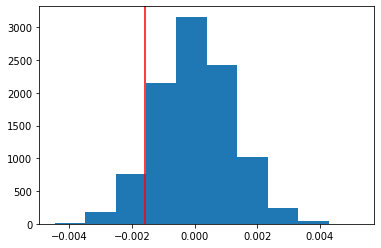

In [21]:
plt.hist(p_diffs);
actual_diffs = treatment_p_converted - control_p_converted
plt.axvline(actual_diffs,color="red");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [22]:
actual_diffs = treatment_p_converted - control_p_converted
(p_diffs>actual_diffs).mean()

0.9074

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**90.44% of the values simulated under the Null Hypothesis are greater than the actual difference observed in ab_data.csv. There is just under a 10% chance under the Null Hypothesis that we would see a more extreme (lower) value... This implied a one-sided p value of 0.9 which is usually not considered strong enough to reject the null. In other words, the new page is not statistically significantly better than the old.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [23]:
# create the groups
convert_old = df2[df2['group']=="control"]['converted'].sum() # number of conversions for old page  
convert_new =  df2[df2['group']=="treatment"]['converted'].sum() # number of conversions for new  
n_old =  len(df2[df2['landing_page']=="old_page"].index) # number of observations i.e., rows for old page
n_new = len(df2[df2['landing_page']=="new_page"].index) # number of observations i.e., rows of new page

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

Notes about Z test:
alternative (string in ['two-sided', 'smaller', 'larger']) – The alternative hypothesis can be either two-sided or one of the one- sided tests, smaller means that the alternative hypothesis is prop < value and larger means prop > value. In the two sample test, smaller means that the alternative hypothesis is p1 < p2 and larger means p1 > p2 where p1 is the proportion of the first sample and p2 of the second one.

In [25]:
count = np.array([convert_old, convert_new ])
nobs = np.array([n_old, n_new])
import statsmodels.api 

stat, pval = statsmodels.stats.proportion.proportions_ztest(count, nobs, value=None, alternative='smaller', prop_var=False) # smaller means alternative is p1 < p2, so old < new

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
print(stat)
print(pval)

1.3109241984234394
0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score of 1.31 means the observed differences are only 1.3 standard deviations away from the mean of the differences expected under the null hypothesis, i.e., we shouldn't reject the null hypothesis;  The p-value of 0.905 is very close to the p-value found in part j**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logisitc**

In [27]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [28]:
# add intercept
df2['intercept']=1

# create dummy variable 
df2[['control','ab_page']] = pd.get_dummies(df2.group)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [29]:
# create model
import statsmodels.api as sm
logit_model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_model.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [30]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-09-10 21:49 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**? **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.1899 so not statististically significant. This value is lower than 0.9. In the logistic regression model, the null hypothesis is "For a switch from control to new landing page the participant is no more likely to convert (and alternative is the participant is more OR less likely to convert). Whereas in the previous analysis we ran a one-sided hypothesis asserting in the alternative hypothesis that the participant was equally OR LESS likely to convert if shown the new landing page.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Other things that might influence whether or not an individual converts is whether they have previously visited the page; what their native language is; their age; perhaps time of day/week; and probably other demographic traits. The disadvantage of adding too many elements is that there may be collinearity or less simplicity in interpreting the results as actionable**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [31]:
df_countries.head()
df_countries['country'].unique()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [34]:
df_countries[['CA','UK','US']] = pd.get_dummies(df_countries['country'])
df_countries

,user_id,country,UK,US,CA
0,834778,UK,1,0,0
1,928468,US,0,1,0
2,822059,UK,1,0,0
3,711597,UK,1,0,0
4,710616,UK,1,0,0
...,...,...,...,...,...
290579,653118,US,0,1,0
290580,878226,UK,1,0,0
290581,799368,UK,1,0,0
290582,655535,CA,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

<a id='conclusions'></a>



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])